# Creating PDFs - a simple introduction

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import zfit

assert tf.executing_eagerly() == False
print("TensorFlow version:", tf.__version__)

DEBUG, sorted dims (0,)
DEBUG, sorted dims (0,)
TensorFlow version: 1.10.0


## Create the data
To store and feed the data, a Dataset is the most comfortable way. While usually files can be used, here we use a numpy generated sample for convenience.

Note here, that while the numpy code gets executed, everything else (the explicit converion, the loading of the file if we had one) is *not yet* executed but a graph is built.

In [2]:
mu_true = 1.
sigma_true = 3.52
np_data = np.random.normal(mu_true, sigma_true, size=10000)
dataset = tf.data.Dataset.from_tensors(tf.cast(np_data, dtype=tf.float64))

# TODO: move the part below (maybe) inside out Dataset or something similar.
data_iterator = dataset.make_one_shot_iterator()  # equal to: no chunksizge; give me the dataset as a whole
data = data_iterator.get_next()  # next junk in a one-chunk iterator is trivial

/home/jonas/anaconda3/envs/zfit36/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


In [3]:
# HACK
data = tf.convert_to_tensor(np_data)
# HACK END

## Create the PDF
There are two ways of creating a pdf: use the provided ones or either define your own (see later/other examples). Here we gonna do the first approach.

The parameters follow the RooFit convention with  
`Parameter(name, initial_value, lower_limit (optional), upper_limit (optional))`

In [4]:
mu = zfit.FitParameter("mu", 2.4, -1., 5., step_size=0.01)
sigma = zfit.FitParameter("sigma", 1.3, -1., 5., step_size=0.01)

gauss1 = zfit.pdf.Gauss(mu=mu, sigma=sigma)
gauss1._integration.draws_per_dim = 10000

The pdf 'gauss1' contains all the usefull functions associated with a pdf.
It is important to note that the normalization range (`norm_range`) for the function always has to be specified *explicitely* (either in the function call, with a context manager or ...)

Let's check out the probability:

In [5]:
small_constants = [1., 3., 5.]
probs = gauss1.prob(tf.constant(small_constants, dtype=tf.float64), norm_range=(0., 5.1))
print("TensorFlow graph for probs", probs)

DEBUG, sorted dims (0,)
DEBUG, max_dims, dims frozenset({0}) (0,)
DEBUG, self._integrals, dims defaultdict(<class 'dict'>, {frozenset({0}): {((-inf, inf),): <function _gauss_integral_from_inf_to_inf at 0x7f9d386fd158>}}) frozenset({0})
DEBUG:, tuple ((0.0, 5.1),)
DEBUG: lower, upper ((0.0,),) ((5.1,),)
DEBUG: lower, upper Tensor("Gauss/prob/Gauss_1/_hook_normalization/Gauss/integrate/Const:0", shape=(1, 1), dtype=float64) Tensor("Gauss/prob/Gauss_1/_hook_normalization/Gauss/integrate/Const_1:0", shape=(1, 1), dtype=float64)
DEBUG, n_dims 1 (0,) 10000 <dtype: 'float64'>
DEBUG, mc_sampler <function sample_halton_sequence at 0x7f9d2a06eb70>
DEBUG, samples_normed Tensor("Gauss/prob/Gauss_1/_hook_normalization/Gauss/integrate/Reshape:0", shape=(1, 10000, 1), dtype=float64)
DEBUG, samples_normed Tensor("Gauss/prob/Gauss_1/_hook_normalization/Gauss/integrate/transpose:0", shape=(1, 1, 10000), dtype=float64)
DEBUG, self._integrals, dims defaultdict(<class 'dict'>, {frozenset({0}): {((-inf, inf

(note here that we did *not yet* get our numerical result, but only a runnable graph)

Let's run our first graph and have a look at the probapilities

In [6]:
sess = tf.Session()
init = tf.global_variables_initializer()  # TODO: make more comfortable this step
sess.run(init)  # TODO: make more comfortable this step
result = sess.run(probs)
print("x values: {}\nresult:   {}".format(small_constants, result))
# Notice here that prob for 1., 3. are the same as sigma is 2.

x values: [1.0, 3.0, 5.0]
result:   [0.18114309 0.29080711 0.04377965]


## Fitting and NLL
As we have our probability at hand, we can use it for a loss function

In [7]:
nll = zfit.unbinned_nll(gauss1.prob(data, norm_range=(-50., 50.)))

DEBUG, sorted dims (0,)
DEBUG, max_dims, dims frozenset({0}) (0,)
DEBUG, self._integrals, dims defaultdict(<class 'dict'>, {frozenset({0}): {((-inf, inf),): <function _gauss_integral_from_inf_to_inf at 0x7f9d386fd158>}}) frozenset({0})
DEBUG:, tuple ((-50.0, 50.0),)
DEBUG: lower, upper ((-50.0,),) ((50.0,),)
DEBUG: lower, upper Tensor("Gauss_1/prob/Gauss_1/_hook_normalization/Gauss/integrate/Const:0", shape=(1, 1), dtype=float64) Tensor("Gauss_1/prob/Gauss_1/_hook_normalization/Gauss/integrate/Const_1:0", shape=(1, 1), dtype=float64)
DEBUG, n_dims 1 (0,) 10000 <dtype: 'float64'>
DEBUG, mc_sampler <function sample_halton_sequence at 0x7f9d2a06eb70>
DEBUG, samples_normed Tensor("Gauss_1/prob/Gauss_1/_hook_normalization/Gauss/integrate/Reshape:0", shape=(1, 10000, 1), dtype=float64)
DEBUG, samples_normed Tensor("Gauss_1/prob/Gauss_1/_hook_normalization/Gauss/integrate/transpose:0", shape=(1, 1, 10000), dtype=float64)
DEBUG, self._integrals, dims defaultdict(<class 'dict'>, {frozenset({0})

In [15]:
from zfit.core.minimizer import AdamMinimizer
minimizer = AdamMinimizer(sess=sess, tolerance=0.2, learning_rate=0.3, beta1=0.9, beta2=0.99)  # from TensorFlow

In [16]:
print("Minimizer created, start minimizing")

Minimizer created, start minimizing


In [17]:
minimium = minimizer.minimize(nll, var_list=[mu, sigma])
print("Minimum:", minimium)

Minimum: 26762.945478199214


In [19]:
mu_val, sigma_val = sess.run([mu.value(), sigma.value()])
print("Fit:  mu = {:.4f}, sigma = {:.4f}".format(mu_val, sigma_val))
print("True: mu = {:.4f}, sigma = {:.4f}".format(mu_true, sigma_true))

Fit:  mu = 0.9739, sigma = 3.5160
True: mu = 1.0000, sigma = 3.5200


In [22]:
# TODO: values are a little bit off...
#stop here  # prevents session close (this raises error with invalid syntax)

In [ ]:
#sess.close()

## Sampling
An automatic accept-reject sampling (with garanteed no bias and linear in speed) is implemented. Let's invoke it:

In [43]:
sample_gauss = gauss1.sample(n_draws=int(1e7), limits=(-10, 10))
sample_gauss_np = sess.run(sample_gauss)  # currently: n_draws not n_returned TODO

DEBUG, sorted dims (0,)
DEBUG:, tuple ((-10, 10),)


Number of generated samples: 4379217


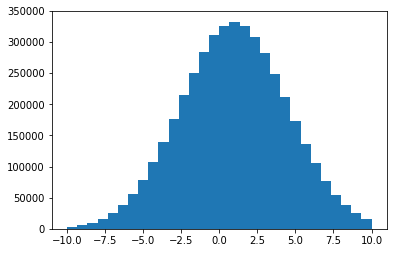

In [46]:
print("Number of generated samples:", len(sample_gauss_np))
_ = plt.hist(sample_gauss_np, bins=30)

## Integrate
Integration is also implemented. This is either normalized if a `norm_range` is specified or unnormalized if `norm_range` is False.

In [47]:
integral_normalized = gauss1.integrate(limits=(-20, 20), norm_range=(-20, 20))
integral_normalized_np = sess.run(integral_normalized)
print("Normalized integral over whole normalization range (should be 1)", integral_normalized_np)

DEBUG, sorted dims (0,)
DEBUG, sorted dims (0,)
DEBUG, max_dims, dims frozenset({0}) (0,)
DEBUG, self._integrals, dims defaultdict(<class 'dict'>, {frozenset({0}): {((-inf, inf),): <function _gauss_integral_from_inf_to_inf at 0x7f9d386fd158>}}) frozenset({0})
DEBUG:, tuple ((-20, 20),)
DEBUG: lower, upper ((-20,),) ((20,),)
DEBUG: lower, upper Tensor("Gauss_15/integrate/Const:0", shape=(1, 1), dtype=float64) Tensor("Gauss_15/integrate/Const_1:0", shape=(1, 1), dtype=float64)
DEBUG, n_dims 1 (0,) 10000 <dtype: 'float64'>
DEBUG, mc_sampler <function sample_halton_sequence at 0x7f9d2a06eb70>
DEBUG, samples_normed Tensor("Gauss_15/integrate/Reshape:0", shape=(1, 10000, 1), dtype=float64)
DEBUG, samples_normed Tensor("Gauss_15/integrate/transpose:0", shape=(1, 1, 10000), dtype=float64)
DEBUG, self._integrals, dims defaultdict(<class 'dict'>, {frozenset({0}): {((-inf, inf),): <function _gauss_integral_from_inf_to_inf at 0x7f9d386fd158>}}) frozenset({0})
DEBUG:, tuple ((-20, 20),)
DEBUG: lowe

In [50]:
integral_unnormalized = gauss1.integrate(limits=(-20, 20), norm_range=False)
integral_unnormalized_np = sess.run(integral_unormalized)
print("Unnormalized integral (this function IS already normalized over the whole space (coincidence))",
      integral_unnormalized_np)

DEBUG, sorted dims (0,)
DEBUG, max_dims, dims frozenset({0}) (0,)
DEBUG, self._integrals, dims defaultdict(<class 'dict'>, {frozenset({0}): {((-inf, inf),): <function _gauss_integral_from_inf_to_inf at 0x7f9d386fd158>}}) frozenset({0})
DEBUG:, tuple ((-20, 20),)
DEBUG: lower, upper ((-20,),) ((20,),)
DEBUG: lower, upper Tensor("Gauss_18/integrate/Const:0", shape=(1, 1), dtype=float64) Tensor("Gauss_18/integrate/Const_1:0", shape=(1, 1), dtype=float64)
DEBUG, n_dims 1 (0,) 10000 <dtype: 'float64'>
DEBUG, mc_sampler <function sample_halton_sequence at 0x7f9d2a06eb70>
DEBUG, samples_normed Tensor("Gauss_18/integrate/Reshape:0", shape=(1, 10000, 1), dtype=float64)
DEBUG, samples_normed Tensor("Gauss_18/integrate/transpose:0", shape=(1, 1, 10000), dtype=float64)
DEBUG, self._integrals, dims defaultdict(<class 'dict'>, {frozenset({0}): {((-inf, inf),): <function _gauss_integral_from_inf_to_inf at 0x7f9d386fd158>}}) frozenset({0})
DEBUG:, tuple ((-20, 20),)
DEBUG: lower, upper ((-20,),) ((20,

In [ ]:
integral_normalized_small = gauss1.integrate(limits=(-20, 20), norm_range=(-0.5, 1.2))
integral_normalized_small_np = sess.run(integral_normalized_small)
print("Unnormalized integral (this function IS already normalized over the whole space (coincidence))",
      integral_normalized_small_np)